# Project: Comprehensive Exploratory Analysis of European Soccer (2008–2016)
## Table of Contents

- [Introduction](#Introduction)
- [Data Wrangling](#Data_Wrangling)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Conclusions](#Conclusions)


## Introduction

<h3>Dataset Description</h3>
<ul>
  <li>
    This soccer database is sourced from <strong>Kaggle</strong> and is well-suited for <strong>data analysis</strong> and <strong>machine learning</strong> applications.
    It contains comprehensive information on soccer <strong>matches, players, and teams</strong> from several European countries, covering the period from <strong>2008 to 2016</strong>.
  </li>
  <li>
    The dataset includes match results, player attributes (e.g., passing, stamina, positioning), team tactics, league associations, and more.
  </li>
  <li>
    In this project, we aim to perform an in-depth exploratory analysis to uncover insights related to team success, player performance, scoring trends, and tactical influence across seasons and leagues.
  </li>
  <li>
    Key questions include: Which teams dominate at home? Who are the most consistent players? How do player physical traits affect ratings? And how have goal trends evolved over time?
  </li>
</ul>


### Question(s) for Analysis

Below are the key questions we aim to explore using the European Soccer dataset:


- [Q1: Average number of goals per match in each season](#Question1)
- [Q2: Team that scored the most goals in a season](#Question2)
- [Q3: Highest win percentage in home vs away games](#Question3)
- [Q4: Teams with the most wins across all seasons](#Question4)
- [Q5: Did BMI affect performance score?](#Question5)
- [Q6: Top 10 players by performance rating](#Question6)




**First, import pandas, numpy, sql, matplotlib,pyplot and seaborn.**

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data_Wrangling




### Connect the Project to the Database

**In this section, I will load the dataset, assess its cleanliness, and perform the necessary trimming and cleaning to prepare it for analysis.**


In [2]:
# Establish connection to the SQLite database file in the same directory
conn = sql.connect("soccer.sqlite")

# Create a cursor object to execute SQL queries
cursor = conn.cursor()


The following code is querying a SQLite database to retrieve the names of all tables present in the database and storing them in a pandas DataFrame.

In [3]:
#get table names
df_tables=pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
#
df_tables.index = np.arange(1, len(df_tables) + 1)
df_tables

,name
1,sqlite_sequence
2,Player_Attributes
3,Player
4,Match
5,League
6,Country
7,Team
8,Team_Attributes


In [4]:
#Extracting the distinct values of the columns containing the names corresponding to the tables.
countries=cursor.execute('''SELECT COUNT(DISTINCT name)
                                FROM Country;''').fetchone()
leagues=cursor.execute('''SELECT COUNT(DISTINCT name)
                                FROM League;''').fetchone()
teams=cursor.execute('''SELECT COUNT(DISTINCT team_long_name)
                                FROM Team;''').fetchone()
players=cursor.execute('''SELECT COUNT(DISTINCT player_name)
                                FROM Player;''').fetchone()


print("Countries: ", countries[0])
print("Leagues: ", leagues[0])
print("Teams: ", teams[0])
print("Players: ", players[0])





Countries:  11
Leagues:  11
Teams:  296
Players:  10848


#### Load Tables

In [28]:
match = pd.read_sql_query("SELECT * FROM Match", conn)
team = pd.read_sql_query("SELECT * FROM Team", conn)
league = pd.read_sql_query("SELECT * FROM League", conn)
player = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [30]:
# Strip whitespace from column names
for df in [match, team, league, player, player_attributes]:
    df.columns = df.columns.str.strip()

#### Convert Data Type 

In [32]:
tables = {
    'Match': match,
    'Team': team,
    'League': league,
    'Player': player,
    'Player_Attributes': player_attributes
}
with pd.option_context('display.max_rows', None, 'display.max_columns', None):

    for name, df in tables.items():
        print(f"Data types for table: {name}")
        print(df.dtypes)
        print('-' * 40)
        

Data types for table: Match
id                    int64
country_id            int64
league_id             int64
season               object
stage                 int64
date                 object
match_api_id          int64
home_team_api_id      int64
away_team_api_id      int64
home_team_goal        int64
away_team_goal        int64
home_player_X1      float64
home_player_X2      float64
home_player_X3      float64
home_player_X4      float64
home_player_X5      float64
home_player_X6      float64
home_player_X7      float64
home_player_X8      float64
home_player_X9      float64
home_player_X10     float64
home_player_X11     float64
away_player_X1      float64
away_player_X2      float64
away_player_X3      float64
away_player_X4      float64
away_player_X5      float64
away_player_X6      float64
away_player_X7      float64
away_player_X8      float64
away_player_X9      float64
away_player_X10     float64
away_player_X11     float64
home_player_Y1      float64
home_player_Y2      

In [33]:
# Convert dates
match['date'] = pd.to_datetime(match['date'])
player_attributes['date'] = pd.to_datetime(player_attributes['date'])


#### Check for Missing Data

In [40]:
# Starting with match column as it is central and largest table in the European Soccer Database
# Check if there is missing data over 60%
missing_percent = match.isnull().mean() * 100
missing_over_60 = missing_percent[missing_percent > 60]
print(missing_over_60.sort_values(ascending=False))


Series([], dtype: float64)


In [5]:
# Adding new columns to the Match table to store related names and identifiers
# These columns will help enhance the data with readable names and player-specific info

cursor.execute('''ALTER TABLE Match 
                  ADD COLUMN "Leagues" TEXT;''')          # Add column for league name

cursor.execute('''ALTER TABLE Match 
                  ADD COLUMN "Countries" TEXT;''')        # Add column for country name

cursor.execute('''ALTER TABLE Match 
                  ADD COLUMN "Home_Team" TEXT;''')        # Add column for home team name

cursor.execute('''ALTER TABLE Match 
                  ADD COLUMN "Away_Team" TEXT;''')        # Add column for away team name



In [6]:
# Update the 'Leagues' column in Match with the corresponding league name
cursor.execute('''Update Match
                  SET Leagues = (
                     SELECT League.name
                     FROM League
                     WHERE League.id =Match.league_id)
                ''')
# Update the 'Countries' column in Match with the corresponding country name

cursor.execute('''Update Match
                  SET Countries = (
                     SELECT Country.name
                     FROM Country
                     WHERE Country.id = Match.country_id)
                ''')
# Update the 'Home_Team' column with the long name of the home team
cursor.execute('''UPDATE Match
                  SET Home_Team = (
                    SELECT Team.team_long_name
                    FROM Team
                    WHERE Team.team_api_id = Match.home_team_api_id)
                ''')

# Update the 'Away_Team' column with the long name of the away team
cursor.execute('''UPDATE Match
                  SET Away_Team = (
                    SELECT Team.team_long_name
                    FROM Team
                    WHERE Team.team_api_id = Match.away_team_api_id)
                ''')

In [7]:
df_match=pd.read_sql_query('SELECT * FROM match',conn)
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,Leagues,Countries,Home_Team,Away_Team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.78,3.25,4.00,1.73,3.40,4.20,Belgium Jupiler League,Belgium,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.85,3.25,3.75,1.91,3.25,3.60,Belgium Jupiler League,Belgium,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,3.20,2.50,2.30,3.20,2.75,Belgium Jupiler League,Belgium,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,1.50,3.75,5.50,1.44,3.75,6.50,Belgium Jupiler League,Belgium,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,4.50,3.50,1.65,4.75,3.30,1.67,Belgium Jupiler League,Belgium,FCV Dender EH,Standard de Liège


# Exploratory-Data-Analysis

#### Question1
#### What is the average number of goals per match in each season?

In [8]:
avg_goals='''
SELECT 
    season,
    round(AVG(home_team_goal + away_team_goal) , 2) AS avg_goals_per_match
FROM Match
GROUP BY season;
'''

avg_goals_df = pd.read_sql_query(avg_goals, conn)
avg_goals_df.head()


,season,avg_goals_per_match
0,2008/2009,2.61
1,2009/2010,2.67
2,2010/2011,2.68
3,2011/2012,2.72
4,2012/2013,2.77


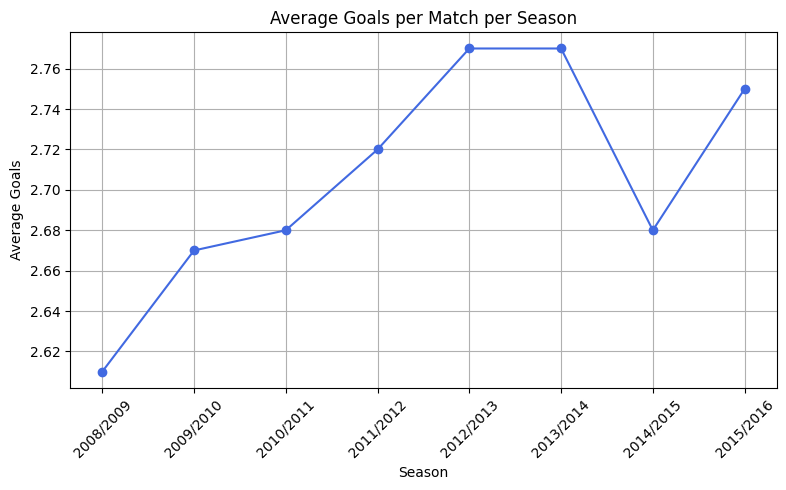

In [9]:

plt.figure(figsize=(8, 5))
plt.plot(avg_goals_df['season'], avg_goals_df['avg_goals_per_match'], marker='o', color='royalblue')
plt.title('Average Goals per Match per Season')
plt.xlabel('Season')
plt.ylabel('Average Goals')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conclusion:
##### The seasons 2013/2014 and 2014/2015 have the highest average number of goals per match, indicating these seasons were the most offensively active compared to others.



#### Question2
#### Which teams scored the most goals in a season?


In [10]:
most_goals = '''
-- Home goals
SELECT 
    season,
    Home_Team AS team,
    SUM(home_team_goal) AS total_goals
FROM Match
GROUP BY season, Home_Team

UNION ALL

-- Away goals
SELECT 
    season,
    Away_Team AS team,
    SUM(away_team_goal) AS total_goals
FROM Match
GROUP BY season, Away_Team
'''



# Load combined goals
goals_df = pd.read_sql_query(most_goals, conn)

# Group again to get total per team per season
season_team_goals = goals_df.groupby(['season', 'team']).sum().reset_index()

# Find top team(s) per season
top_teams = season_team_goals.sort_values(['season', 'total_goals'], ascending=[True, False])\
                             .groupby('season').head(1).reset_index(drop=True)

top_teams


,season,team,total_goals
0,2008/2009,FC Barcelona,105
1,2009/2010,Ajax,106
2,2010/2011,Real Madrid CF,102
3,2011/2012,Real Madrid CF,121
4,2012/2013,FC Barcelona,115
5,2013/2014,Real Madrid CF,104
6,2014/2015,Real Madrid CF,118
7,2015/2016,FC Barcelona,112


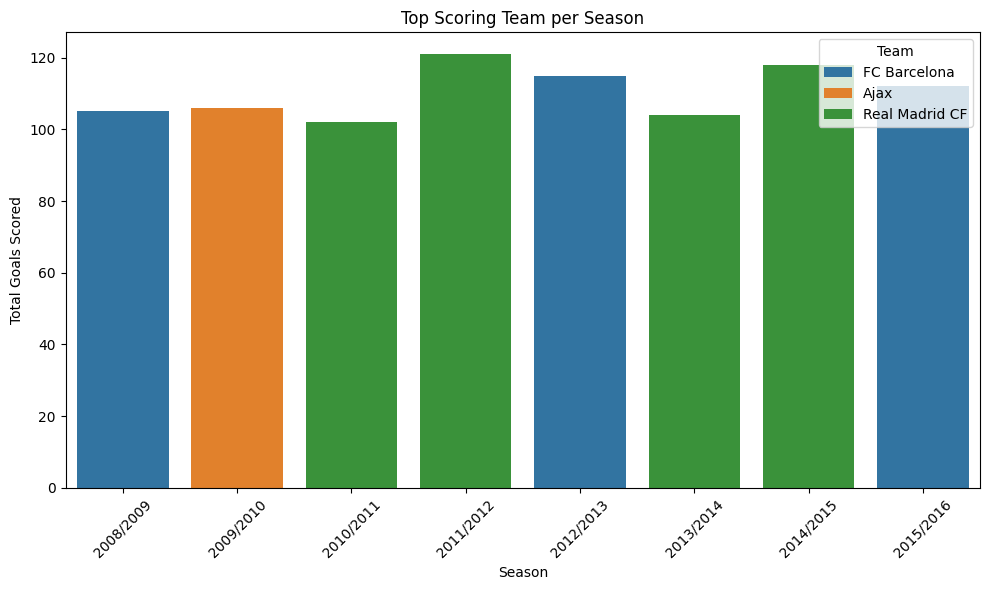

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='total_goals', hue='team', data=top_teams, dodge=False)
plt.title('Top Scoring Team per Season')
plt.xlabel('Season')
plt.ylabel('Total Goals Scored')
plt.xticks(rotation=45)
plt.legend(title='Team')
plt.tight_layout()
plt.show()

#### Conclusion:
#### Over the 8 seasons analyzed, Real Madrid scored the most goals in 4 seasons, while Barcelona led in 3 seasons. This highlights the consistent offensive strength of these two clubs during the period.

#### Question3 
#### Which teams have the highest win percentage in home games vs. away games?

In [12]:
highest_home_percent='''
WITH home_stats AS (
    SELECT 
        home_team_api_id AS team_api_id,
        COUNT(*) AS home_games,
        SUM(CASE WHEN home_team_goal > away_team_goal THEN 1 ELSE 0 END) AS home_wins,
        ROUND(SUM(CASE WHEN home_team_goal > away_team_goal THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS home_win_percent
    FROM Match
    GROUP BY home_team_api_id
),
away_stats AS (
    SELECT 
        away_team_api_id AS team_api_id,
        COUNT(*) AS away_games,
        SUM(CASE WHEN away_team_goal > home_team_goal THEN 1 ELSE 0 END) AS away_wins,
        ROUND(SUM(CASE WHEN away_team_goal > home_team_goal THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS away_win_percent
    FROM Match
    GROUP BY away_team_api_id
)
SELECT
    t.team_long_name,
    COALESCE(hs.home_games, 0) AS home_games,
    COALESCE(hs.home_wins, 0) AS home_wins,
    COALESCE(hs.home_win_percent, 0) AS home_win_percent,
    COALESCE(aw.away_games, 0) AS away_games,
    COALESCE(aw.away_wins, 0) AS away_wins,
    COALESCE(aw.away_win_percent, 0) AS away_win_percent
FROM Team t
LEFT JOIN home_stats hs ON t.team_api_id = hs.team_api_id
LEFT JOIN away_stats aw ON t.team_api_id = aw.team_api_id
ORDER BY home_win_percent DESC



'''
final = pd.read_sql_query(highest_home_percent, conn)
final.head(15)


,team_long_name,home_games,home_wins,home_win_percent,away_games,away_wins,away_win_percent
0,FC Barcelona,152,131,86.18,152,103,67.76
1,Real Madrid CF,152,129,84.87,152,99,65.13
2,FC Porto,124,102,82.26,124,81,65.32
3,SL Benfica,124,102,82.26,124,83,66.94
4,FC Bayern Munich,136,109,80.15,136,84,61.76
5,Celtic,152,120,78.95,152,98,64.47
6,PSV,136,105,77.21,136,73,53.68
7,Manchester United,152,116,76.32,152,76,50.00
8,Ajax,136,103,75.74,136,78,57.35
9,RSC Anderlecht,106,79,74.53,106,57,53.77


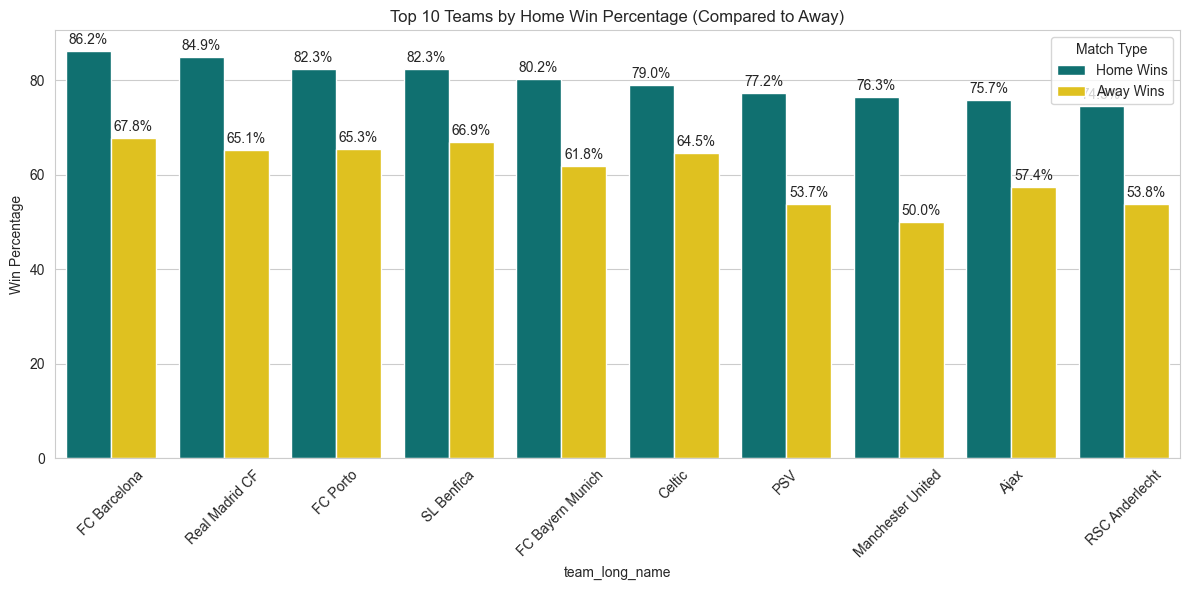

In [20]:

custom_palette = {
    'Home Wins': '#008080',  
    'Away Wins': '#FFD700'  
}

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=plot_data,
    x='team_long_name',
    y='Win Percentage',
    hue='Match Type',
    palette=custom_palette
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

# Final touches
plt.title('Top 10 Teams by Home Win Percentage (Compared to Away)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**This plot illustrates the home and away win percentages of the top 10 teams with the highest home win rates, emphasizing their comparative performance in home and away matches.**

#### Question4
#### Which teams have achieved the most wins across all seasons and leagues combined?

In [21]:
most_wins = '''
WITH home_wins AS (
    SELECT
        season,
        home_team_api_id AS team_api_id,
        COUNT(*) AS home_wins
    FROM Match
    WHERE home_team_goal > away_team_goal
    GROUP BY season, home_team_api_id
),
away_wins AS (
    SELECT
        season,
        away_team_api_id AS team_api_id,
        COUNT(*) AS away_wins
    FROM Match
    WHERE away_team_goal > home_team_goal
    GROUP BY season, away_team_api_id
),
all_wins AS (
    SELECT
        COALESCE(hw.team_api_id, aw.team_api_id) AS team_api_id,
        hw.season,
        COALESCE(hw.home_wins, 0) AS home_wins,
        COALESCE(aw.away_wins, 0) AS away_wins
    FROM home_wins hw
    FULL OUTER JOIN away_wins aw ON hw.team_api_id = aw.team_api_id AND hw.season = aw.season
)

SELECT
    aw.season,
    t.team_long_name,
    aw.home_wins,
    aw.away_wins,
    (aw.home_wins + aw.away_wins) AS total_wins
FROM all_wins aw
JOIN Team t ON aw.team_api_id = t.team_api_id
WHERE aw.season IS NOT NULL     
ORDER BY aw.season, total_wins DESC;



'''

result = pd.read_sql_query(most_wins, conn)

result



,season,team_long_name,home_wins,away_wins,total_wins
0,2008/2009,Manchester United,16,12,28
1,2008/2009,FC Barcelona,14,13,27
2,2008/2009,Rangers,15,11,26
3,2008/2009,Chelsea,11,14,25
4,2008/2009,Real Madrid CF,14,11,25
...,...,...,...,...,...
1475,2015/2016,Académica de Coimbra,5,0,5
1476,2015/2016,Polonia Bytom,2,2,4
1477,2015/2016,SC Cambuur,2,1,3
1478,2015/2016,ES Troyes AC,1,2,3


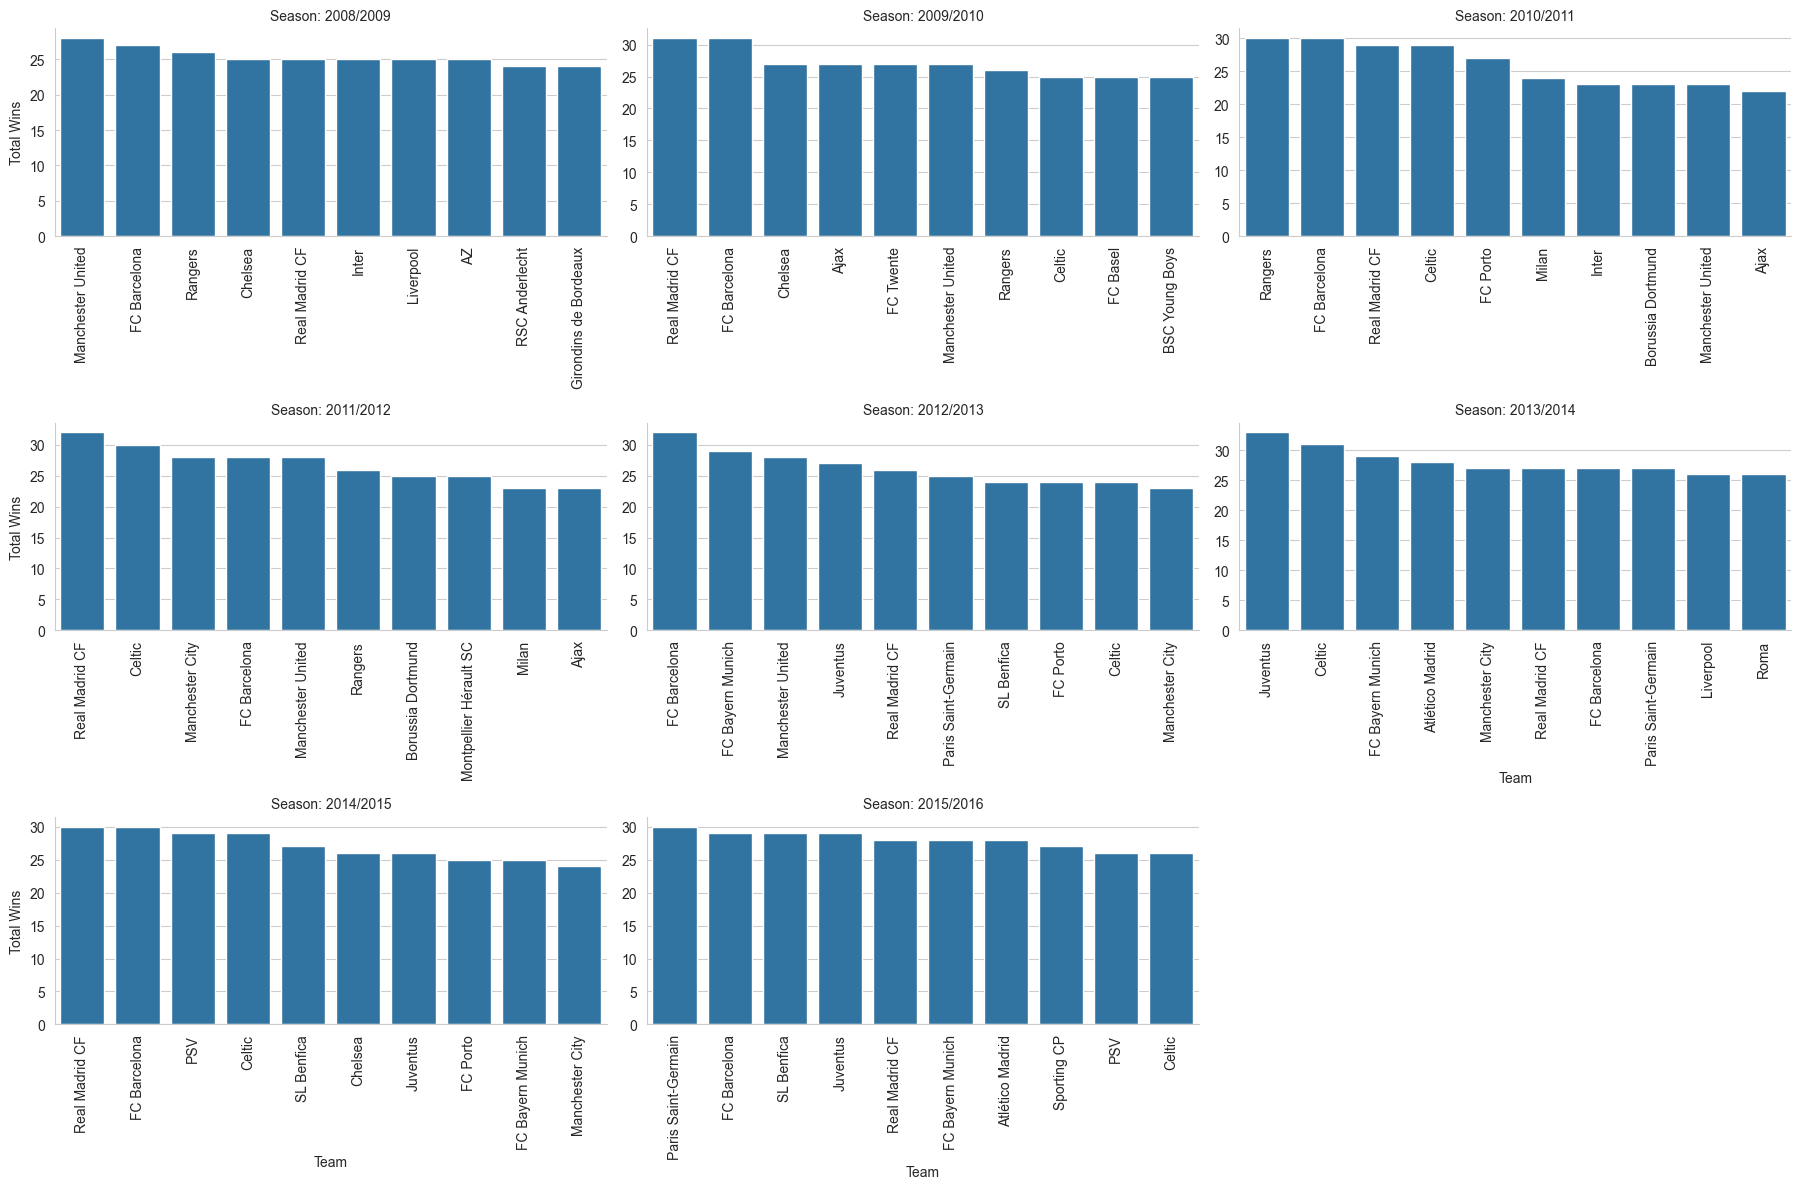

In [41]:
top_10_per_season = (
    result
    .sort_values(['season', 'total_wins'], ascending=[True, False])
    .groupby('season')
    .head(10)  # select top 10 rows per season
)

g = sns.catplot(
    data=top_10_per_season,
    x='team_long_name',
    y='total_wins',
    col='season',
    kind='bar',
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5
)

g.set_xticklabels(rotation=90)
g.set_titles("Season: {col_name}")
g.set_axis_labels("Team", "Total Wins")
plt.tight_layout()
plt.show()

#### Conclusion:
**This plot shows the top 10 teams with the most wins across all seasons. It highlights how their total wins vary season by season, revealing periods of dominance and consistency**

#### Question5
#### Did the Body Mass Index (BMI) of the players affect their performance score (overall rating)?

In [23]:
bmi='''
SELECT
    p.player_fifa_api_id,
    p.player_name,
    p.height,
    p.weight,
    ROUND((p.weight * 0.453592) / ((p.height / 100.0) * (p.height / 100.0)), 2) AS bmi,
    pa.overall_rating
FROM Player p
JOIN Player_Attributes pa
    ON p.player_fifa_api_id = pa.player_fifa_api_id
WHERE pa.overall_rating IS NOT NULL
  AND p.height IS NOT NULL
  AND p.weight IS NOT NULL
'''

bmi_df=pd.read_sql_query(bmi, conn)
bmi_df


,player_fifa_api_id,player_name,height,weight,bmi,overall_rating
0,218353,Aaron Appindangoye,182.88,187,25.36,67
1,218353,Aaron Appindangoye,182.88,187,25.36,67
2,218353,Aaron Appindangoye,182.88,187,25.36,62
3,218353,Aaron Appindangoye,182.88,187,25.36,61
4,218353,Aaron Appindangoye,182.88,187,25.36,61
...,...,...,...,...,...,...
183137,102359,Zvjezdan Misimovic,180.34,176,24.55,83
183138,102359,Zvjezdan Misimovic,180.34,176,24.55,78
183139,102359,Zvjezdan Misimovic,180.34,176,24.55,77
183140,102359,Zvjezdan Misimovic,180.34,176,24.55,78


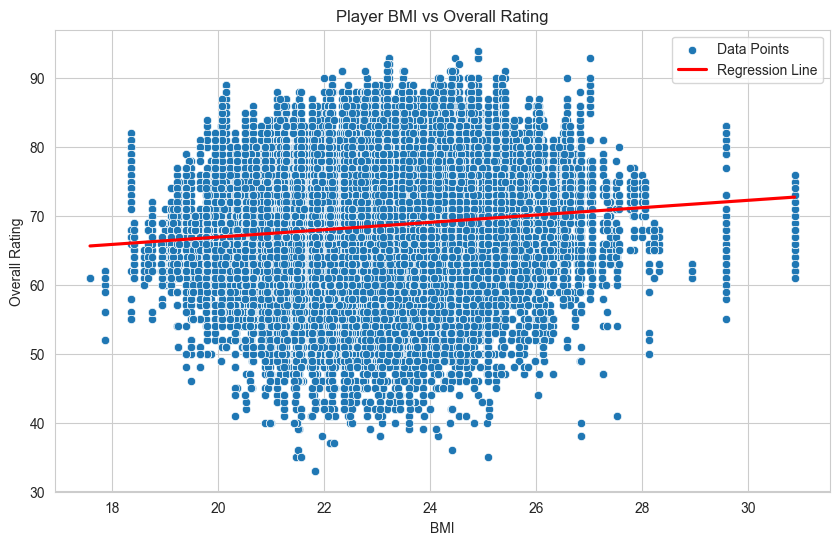

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bmi_df, x='bmi', y='overall_rating')
sns.regplot(data=bmi_df, x='bmi', y='overall_rating', scatter=False, color='red')
plt.title('Player BMI vs Overall Rating')
plt.xlabel('BMI')
plt.ylabel('Overall Rating')
plt.grid(True)
plt.legend(['Data Points ',"Regression Line"])
plt.show()

In [25]:
correlation = bmi_df['bmi'].corr(bmi_df['overall_rating'])
print(correlation)

0.1014149947166252


#### Conclusion:
**The correlation between BMI and overall rating is very weak (close to 0), indicating that BMI has little to no effect on a player’s performance. This is also reflected in the scatter plot, where data points are widely spread and the trendline is almost flat.**

#### Question6
#### Who were the top ten players with the highest performance scores (overall ratings) across all seasons and leagues during the entire duration?


In [26]:
rating='''
SELECT p.player_name,
       ROUND(AVG(pa.overall_rating), 2) AS avg_overall_rating
FROM Player p
JOIN Player_Attributes pa
ON p.player_fifa_api_id = pa.player_fifa_api_id
GROUP BY p.player_fifa_api_id, p.player_name
ORDER BY avg_overall_rating DESC
'''
rating_df=pd.read_sql_query(rating, conn)
rating_df.head(10)


,player_name,avg_overall_rating
0,Lionel Messi,92.19
1,Cristiano Ronaldo,91.28
2,Franck Ribery,88.46
3,Andres Iniesta,88.32
4,Zlatan Ibrahimovic,88.29
5,Arjen Robben,87.84
6,Xavi Hernandez,87.64
7,Wayne Rooney,87.22
8,Iker Casillas,86.95
9,Philipp Lahm,86.73


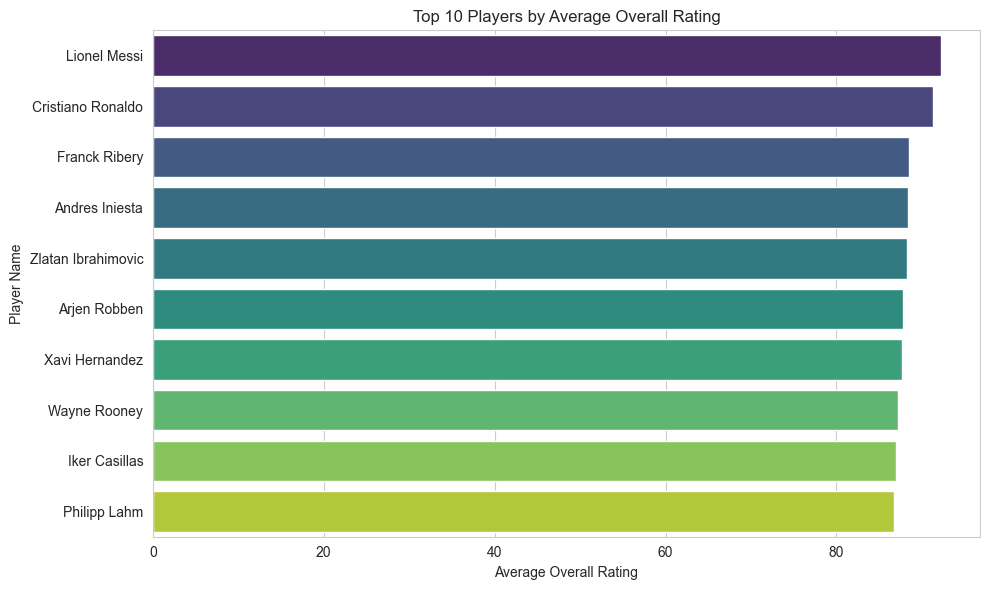

In [27]:
# Get top 10 players by average rating
top_10_rating_df = rating_df.nlargest(10, 'avg_overall_rating').sort_values('avg_overall_rating',ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_rating_df,
    x='avg_overall_rating',
    y='player_name',
    hue='player_name',       # assign hue to match `y`
    palette='viridis',
    dodge=False,             # avoids separating bars
    legend=False             # no need for a redundant legend
)

plt.title('Top 10 Players by Average Overall Rating')
plt.xlabel('Average Overall Rating')
plt.ylabel('Player Name')
plt.tight_layout()
plt.show()


#### Conclusion:
**The top ten players with the highest overall performance scores across all seasons and leagues demonstrate exceptional skill and consistency throughout their careers. These players stand out as the most impactful and valuable in the dataset during the entire period analyzed.**

# Conclusions

### This comprehensive analysis of European soccer data across multiple seasons and leagues reveals several key insights. Teams like Real Madrid and Barcelona consistently dominate in goals scored and wins, reflecting their sustained excellence. Home advantage plays a significant role, with certain teams showing notably higher home win percentages. The top players identified exhibit outstanding performance ratings, underscoring their critical impact on match outcomes. Together, these findings highlight the competitive dynamics and trends shaping European soccer over the analyzed period, providing valuable perspectives for fans, analysts, and stakeholders alike.

